## Table of Contents
1. [TF-IDF Split](#tfidf)
2. [Baseline Model](#base)
3. [Initial Models](#initial)
4. [Grid Search](#grid)
5. [Final Model](#final)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from custom import * #personal functions
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from scipy import sparse
import pickle

In [5]:
df = pd.read_pickle('../Data/classify_reviews.pkl')
df.head()

,Review,Score
0,\n Keough's...,1
1,\n While Th...,1
2,"\n If ""The ...",1
3,"\n ""The Lod...",1
4,\n There's ...,0


# TF-IDF Split <a id='tfidf'></a>

In [6]:
tf_idf_data = sparse.load_npz("tf_idf.npz")

In [7]:
tf_idf_data.shape

(9174, 98742)

In [25]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [8]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(tf_idf_data, df['Score'], random_state=13)

# Baseline Model  <a id='base'></a>

First, let's make a dummy model which always predicts the majority class. We'll use this as a comparison for all of our actual models.

In [9]:
# Create dummy classifer
dummy = DummyClassifier(strategy='most_frequent', random_state=1)

# "Train" model
dummy.fit(X_train, y_train)

DummyClassifier(random_state=1, strategy='most_frequent')

In [10]:
summary_df = pd.DataFrame(columns=['Model','Accuracy', 'Recall', 'Precision',  'F1'])
predictions = dummy.predict(X_test)
summary_df = summary_df.append({'Model': 'Dummy',
   'Accuracy': metrics.accuracy_score(y_test, predictions),
   'Recall': metrics.recall_score(y_test, predictions),
   'Precision': metrics.precision_score(y_test, predictions), 
   'F1': metrics.f1_score(y_test, predictions)},ignore_index=True)
summary_df

,Model,Accuracy,Recall,Precision,F1
0,Dummy,0.563208,1.0,0.563208,0.72058


In [11]:
print(f"The majority class is {predictions[0]}.")

The majority class is 1.


Here, we can see the dummy model is predicting only class "1". This gives us a recall of 1 (obviously), and an accuracy and precision of 0.55. Let's hope our models will need to do better than this!

# Initial Models <a id='initial'></a>

Using my classification_models() function, let's create models with only the default parameters.

In [12]:
models = ['logistic','knn','tree','rf','AdaBoost','xgb','GrdBoost','svc','Bayes']
classification_models(tf_idf_data,df['Score'],models)

Using logistic
Using knn
Using tree
Using rf
Using AdaBoost
Using xgb
Using GrdBoost
Using svc
Using Bayes


,Model,Accuracy,Recall,Precision,F1
0,logistic,0.732425,0.890490,0.710890,0.790618
1,knn,0.488828,0.259366,0.617849,0.365359
2,tree,0.648501,0.658982,0.702869,0.680218
3,rf,0.732425,0.801153,0.745975,0.772580
4,AdaBoost,0.624523,0.929875,0.611111,0.737524
5,xgb,0.635422,0.897214,0.624332,0.736303
6,GrdBoost,0.653406,0.897214,0.638414,0.746006
7,svc,0.743324,0.912584,0.714286,0.801350
8,Bayes,0.719891,0.942363,0.683624,0.792407


# Grid Search <a id ='grid'></a>

We want to prioritize accuracy in our text classification, and the best of these models are SVC, Logistic Regression, Random Forest, and Multinomial Naive Bayes. We want to pick 3 models from these to improve on. Random Forest has the lowest F1 score of these, which takes into account both precision and recall, so we'll drop it. Let's check to see if using gridsearch gets us any better results.

In [13]:
grid_models = ['logistic','svc','Bayes']
param_grid = [{'C': np.logspace(-4, 4, 20),
              'fit_intercept': [True, False],
              'max_iter': [1_000,10_000],
              'warm_start': [False,True]}, #logistic
              {'C' : np.linspace(0.01,10,6),
              'kernel': ['rbf', 'poly', 'sigmoid'],
              'degree': [3,2],
              'gamma': ['scale','auto'],
              'shrinking': [True, False]}, #svc
              {'alpha': [1,0.5],
              'fit_prior': [True, False]}] #bayes

In [14]:
classification_models(tf_idf_data,df['Score'],grid_models,param_grid=param_grid,grid=True)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:  6.2min finished


logistic's best parameters are {'C': 11.288378916846883, 'fit_intercept': True, 'max_iter': 1000, 'warm_start': False}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 58.0min finished


svc's best parameters are {'C': 2.008, 'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid', 'shrinking': True}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Bayes's best parameters are {'alpha': 1, 'fit_prior': False}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


,Model,Accuracy,Recall,Precision,F1
0,logistic,0.763488,0.809798,0.781279,0.795283
1,svc,0.765668,0.802113,0.788480,0.795238
2,Bayes,0.762398,0.836695,0.766051,0.799816


It looks like my best model is SVC, with an accuracy slightly better than our two other models. Let's analyze this model's results further.

# Final Model <a id='final'></a>

I'll use the same train/test set created earlier for the baseline model and pass it to an SVC model with the parameters we just found using grid search. I don't include the degree parameter since we are using a "sigmoid" kernel, which ignores this parameter. Our grid search also told me that the best gamma and shrinking parameters are the defaults, so there's no need to include them when I create the model. 

In [17]:
model = SVC(C = 2.008, kernel = 'sigmoid')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [18]:
summary_df = pd.DataFrame(columns=['Model','Accuracy', 'Recall', 'Precision', 'F1'])
summary_df = summary_df.append({'Model': 'SVC',
                   'Accuracy': metrics.accuracy_score(y_test, y_pred),
                   'Recall': metrics.recall_score(y_test, y_pred),
                   'Precision': metrics.precision_score(y_test, y_pred), 
                   'F1': metrics.f1_score(y_test, y_pred)},ignore_index=True)
summary_df

,Model,Accuracy,Recall,Precision,F1
0,SVC,0.752398,0.794892,0.77218,0.783371


A confusion matrix will help us visualize these metrics.

In [19]:
cm = confusion_matrix(y_test, y_pred)
classes = model.classes_

Confusion Matrix, without normalization


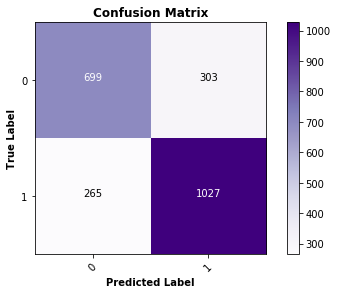

In [20]:
plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples)

In [21]:
true_positives, true_negatives, false_positives, false_negatives = generate_confusion_indices(y_test, y_pred)

True positives: 1027
True negatives: 699
False positives: 303
False negatives: 265


Let's look at the top words for the false positives and false negatives.

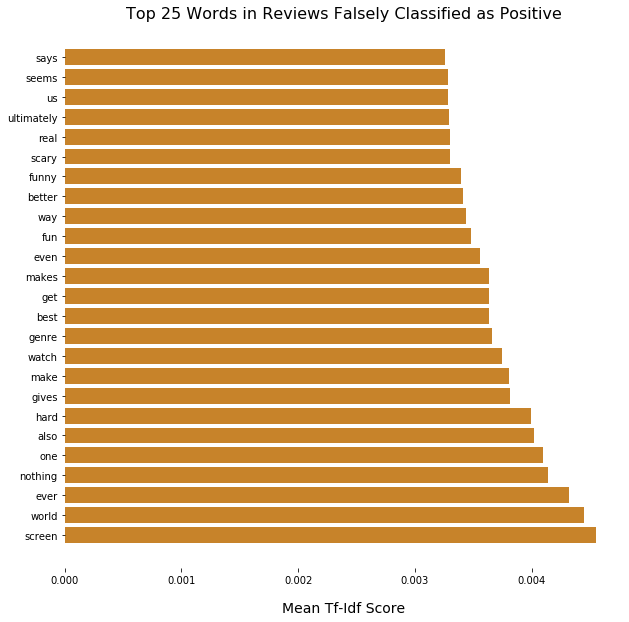

In [28]:
top_fp_words = top_mean_feats(tf_idf_data, features, grp_ids=false_positives)
fig, ax = plt.subplots(figsize=(10, 10), facecolor="w")
ax.set_frame_on(False)
ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
ax.set_title("Top 25 Words in Reviews Falsely Classified as Positive", fontsize=16)
ax.barh(top_fp_words['Feature'], top_fp_words['TF-IDF'], align='center', color='#c7832a')
plt.savefig(f'../Images/top_fp_words.png')

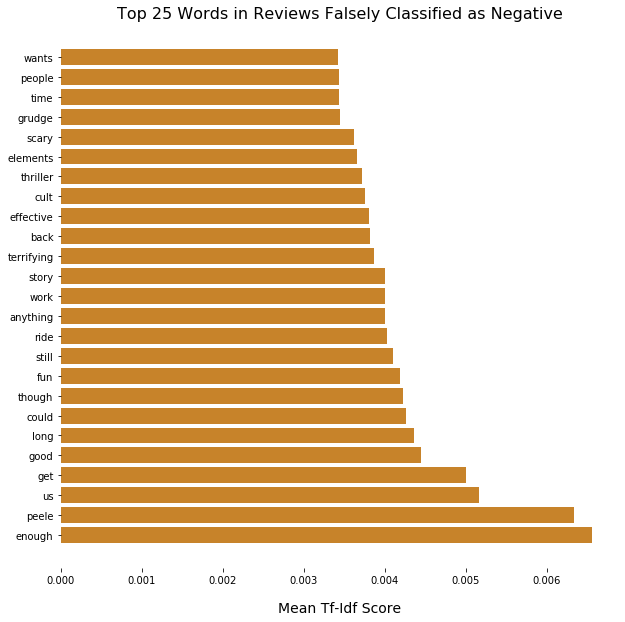

In [29]:
top_fn_words = top_mean_feats(tf_idf_data, features, grp_ids=false_negatives)
fig, ax = plt.subplots(figsize=(10, 10), facecolor="w")
ax.set_frame_on(False)
ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
ax.set_title("Top 25 Words in Reviews Falsely Classified as Negative", fontsize=16)
ax.barh(top_fn_words['Feature'], top_fn_words['TF-IDF'], align='center', color='#c7832a')
plt.savefig(f'../Images/top_fn_words.png')

We can now compare these to the most important words per class of review.

![Top Words Per Class](../Images/top_words_per_class.png)

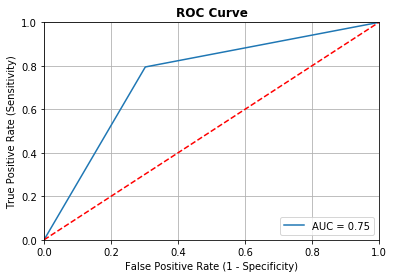

In [22]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve', fontweight='bold')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.savefig('../Images/roc_curve.png')

# Show the grid lines as dark grey lines
plt.grid(b=True, which='major', linestyle='-')

The AUC shows this model has a 75% change of distinguishing between negative and positive reviews.